# Question answering

This notebook shows how the Question answering/ query process works which tackles objectve 5.a.2 (Identify recommended procedure for a given situation).

The system works by first finding k most similar sentences from the Rule books to the Question. 

Then these sentences are re-ranked by a cross-encoder which is trained to rank pairs of question 
and answer sentence, based on the likelihood of the answer being in the sentence. 

Then for the top n sentences from the cross encoder score, a different model selects what it 
thinks the answer is. 

In [1]:
import sys
import pickle
sys.path.insert(1, '../')
from model_calls import qa_inference
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer, CrossEncoder

/home/mattmdjaga/anaconda3/envs/rssb_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the handbooks and modules data and transforming it to {sentence : source book} format.

In [3]:
data = pickle.load(open("../data/handbooks_parts.pt",'rb'))
data_1 = pickle.load(open("../data/modules_parts.pt",'rb'))
data.extend(data_1)
text = []
from collections import defaultdict
books = defaultdict(list)
for x in data:
    sentence = f"{x['section']}. {x['sentence']}"
    title = f"{x['title']}. {x['sub_title']}"
    if sentence not in text:
        text.append(sentence)
    books[sentence].append(title)

Loading the models. The custom embedder is specifically made for RSSB data. 

The other 2 models are just popular, compact and accurate models.

roberta base squad 2 is the answer selection model.

ms-macro miniLM L 6 v2 is the cross encoder

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedder = SentenceTransformer('../models/custom_embedder', device)
embeddings = embedder.encode(text, convert_to_tensor=True)
answer_selection_model = "deepset/roberta-base-squad2"
nlp = pipeline('question-answering', model=answer_selection_model, tokenizer=answer_selection_model)
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Inferencing the q&a pipeline.

embedder (Sentence Transformers or Hugging Face embedder): Model which is used to embed the sentences and answers into a high dimensional space.

corpus_embedding (list[embeddings]): List of embeddings for each sentence in the corpus.

cross_encoder (Sentence Transformers or Hugging Face model): Model which is used to rank the sentences and answers.

In [9]:
qs = ['What does swl mean?','How to report to the signaller?', 'Can the site warden use their phone?', 'What to do when a train fails?']
res = qa_inference(embedder=embedder,corpus_embeddings=embeddings, cross_encoder=cross_encoder, qa_pipeline=nlp,text=text, qs=qs, books=books,n=1)

In [11]:
for k,v in res.items():
    print(f"Question {k}")
    print(f"Answer sentence: {v[0][0]}")
    print(f"Cross Encoder score: {v[0][1]}")
    print(f"Answer: {v[0][2]}")
    print(f"Source: {v[0][3]}")
    print('\n')

Question What does swl mean?
Answer sentence: 1 Definitions. Work site - Each work site is under the control of an engineering supervisor (ES) or safe work leader (SWL). The ES or SWL is responsible for authorising the movement of engineering trains or OTP entering or within the work site.
Cross Encoder score: 5.22925329208374
Answer: safe work leader
Source: ['Handbook 9. IWA or COSS setting up safe systems of work within possessions', 'Handbook 15. Duties of the machine controller (MC) and on-track plant operator']


Question How to report to the signaller?
Answer sentence: 3.2 Reporting to the signaller. You must tell the signaller when the OTM has passed clear of any location that the signaller has specified.
Cross Encoder score: 7.5992841720581055
Answer: when the OTM has passed clear of any location
Source: ['OTM. Working of on-track machines (OTM)']


Question Can the site warden use their phone?
Answer sentence: 3 Site-warden duties. While you are acting as a site warden you mu

A list of questions which were used to test accuracy.

In [ ]:
qs = ['How to use communications equipment?', 'What work can be done without a blocked line?',
'What does ABCL mean?','When is a lookout needed?','How to report an accident',
'What does a signaller do?', 'What to do when you see a flood?', 'What does ECO mean?', 
'When are distant lookout allowed?', 'Can you use a mobile phone while acting as a site warden?',
'How must you give the warning as instructed by the COSS or SWL?',
'What must you do when you see the distant lookout giving the warning?', 
'What must you have with you to act as a lookout?',
'Who will make sure you understand the limits of the safe area?',
'How far apart should detonators be placed?',
'Under what conditions should the signaller place detonator protection?',
'Who will make sure you understand the limits of the safe area?',
"What must you do while acting as a site warden?", 'Why must you watch the group?',
'How must you give the warning as instructed by the COSS or SWL?']

Accuracy of different q&a setups. Current method is 'custom embedder top 16' and the 
other 2 show the difference of using the first sentence from semantic similarity (embedder)
with the custom embedder and a default embedder ('all-MiniLM-L6-v2')

In [1]:
acc = [((16/17) * 100),((12/17) * 100),((8/17) * 100)]
acc

[94.11764705882352, 70.58823529411765, 47.05882352941176]

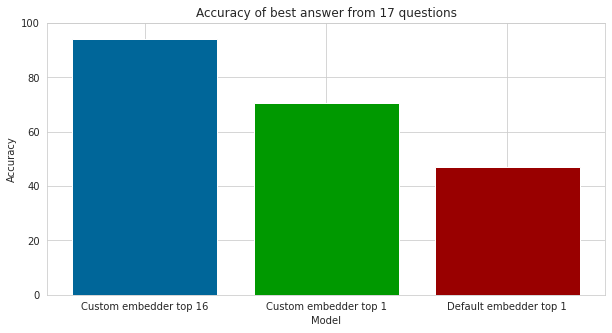

In [3]:
# Plot accuracy as a bar plot, x axis should be 'Best, 'Custom 1 sentence', 'Default 1 sentence'. Make the plot look nice.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(['Custom embedder top 16','Custom embedder top 1','Default embedder top 1'],acc, color=[ '#006699', '#009900', '#990000'])
plt.title('Accuracy of best answer from 17 questions')
plt.xlabel('Model')
plt.ylabel('Accuracy')
ax.set_ylim([0,100])
plt.show()
#fig.savefig('q_a_acc.png')